## Airplane Data - Regression

In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.3.1-bin-hadoop2'

In [2]:
import os
import py4j
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import mean,countDistinct, avg,stddev, col, count, when
import pyspark.sql.functions as F

from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer, OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #for plotting
from sklearn.preprocessing import LabelEncoder

In [3]:
# Lets set a random seed for notebook reproducability
rnd_seed= 42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [4]:
spark = SparkSession.builder.appName("cal_example").getOrCreate()
spark

#### Imported already cleaned data with encoded categorical data

In [5]:
airplane = spark.read.csv('./airplane_cleaned.csv',header = True, inferSchema = True)
airplane.columns

['_c0', 'Operator', 'Aboard', 'Fatalities', 'Year', 'Month', 'Operator_coded']

In [6]:
final_df = airplane.select('Fatalities','Aboard', 'Year', 'Month', 'Operator_coded')

#### Extracting the Features

In [7]:
featurecols = ['Aboard', 'Year', 'Month', 'Operator_coded']

In [8]:
#using VectorAssembler, we can put features into a feature vector column:
#Reference: https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html
assembler = VectorAssembler(inputCols=featurecols, outputCol="features")
assembler

VectorAssembler_64b34d93606b

In [9]:
assembled_df = assembler.transform(final_df)
assembled_df.show(5)

+----------+------+----+-----+--------------+--------------------+
|Fatalities|Aboard|Year|Month|Operator_coded|            features|
+----------+------+----+-----+--------------+--------------------+
|       1.0|   2.0|1908|    9|             1|[2.0,1908.0,9.0,1.0]|
|       5.0|   5.0|1912|    7|             1|[5.0,1912.0,7.0,1.0]|
|       1.0|   1.0|1913|    8|             0|[1.0,1913.0,8.0,0.0]|
|      14.0|  20.0|1913|    9|             1|[20.0,1913.0,9.0,...|
|      30.0|  30.0|1913|   10|             1|[30.0,1913.0,10.0...|
+----------+------+----+-----+--------------+--------------------+
only showing top 5 rows



#### Standerdising the data using MinMaxScaler()

In [10]:
# Initialize the `standardScaler`
minmaxScaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

In [11]:
#fitting our dataframe to the scaler
scaled_df = minmaxScaler.fit(assembled_df).transform(assembled_df)

In [12]:
#looking at how our feature values changed
scaled_df.select("features", "features_scaled").show(5)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[2.0,1908.0,9.0,1.0]|[0.00310559006211...|
|[5.0,1912.0,7.0,1.0]|[0.00776397515527...|
|[1.0,1913.0,8.0,0.0]|[0.00155279503105...|
|[20.0,1913.0,9.0,...|[0.03105590062111...|
|[30.0,1913.0,10.0...|[0.04658385093167...|
+--------------------+--------------------+
only showing top 5 rows



In [13]:
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed) ## splitting the train and test data

In [14]:
rmse = []
mae = []
r2 = []

## MLR

In [15]:
##Creating the model
lin_model = (LinearRegression(featuresCol='features_scaled', labelCol="Fatalities", predictionCol='predfatalities', 
                               maxIter=10, regParam=0.3, standardization=False))

In [16]:
# Fit the data to the model
linearModel = lin_model.fit(train_data)

In [17]:
# Coefficients for the model
linearModel.coefficients
linearModel.coefficients.toArray()

array([129.62021498,   8.47273041,   1.72475196,   5.62161941])

In [18]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featurecols,
                         "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})

#### Generating the predictions for MLR

In [19]:
# Generate predictions
predictions = linearModel.transform(test_data)
#predictions.show(10)

In [20]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predfatalities", "Fatalities")

In [21]:
predandlabels.show()

+------------------+----------+
|    predfatalities|Fatalities|
+------------------+----------+
|18.230770108722226|       0.0|
|14.695379985869767|       0.0|
| 13.87901136514785|       0.0|
|15.796064577969997|       0.0|
|17.217034836408345|       0.0|
| 23.75383212917732|       0.0|
| 26.51931885351089|       0.0|
| 32.11667627550634|       0.0|
| 43.95777024478595|       0.0|
|46.328022596631065|       0.0|
| 43.70607232809142|       0.0|
|47.861343151280806|       0.0|
|49.503336794553235|       0.0|
| 74.10488927748608|       0.0|
| 9.880796427974367|       1.0|
| 9.651093582854532|       1.0|
| 9.107799472686814|       1.0|
|  9.61112999225512|       1.0|
|10.949383472374713|       1.0|
|10.092498097159108|       1.0|
+------------------+----------+
only showing top 20 rows



#### Evaluating MLR

In [22]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

rmse.append(linearModel.summary.rootMeanSquaredError)
mae.append(linearModel.summary.meanAbsoluteError)
r2.append(linearModel.summary.r2)

RMSE: 27.714706893957263
MAE: 15.384636667509618
R2: 0.33638194756662965


### Lasso

In [23]:
## creating the model
lasso_model = (LinearRegression(featuresCol='features_scaled', labelCol="Fatalities", predictionCol='predictFatalities', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.3, standardization=False))

In [24]:
# Fit the data to the model
lassoModel = lasso_model.fit(train_data)

In [25]:
# Coefficients for the model
lassoModel.coefficients
lassoModel.coefficients.toArray()

array([153.464086  ,   6.24052139,   0.72899988,   5.01275523])

In [26]:
# Intercept for the model
lassoModel.intercept

8.326702898922514

In [27]:
coeff_df1 = pd.DataFrame({"Feature": ["Intercept"] + featurecols,
                         "Co-efficients": np.insert(lassoModel.coefficients.toArray(), 0, lassoModel.intercept)})

#### Generating the predictions for Lasso

In [28]:
# Generate predictions
predictions1 = lassoModel.transform(test_data)
predictions1.show(2)

+----------+------+----+-----+--------------+--------------------+--------------------+------------------+
|Fatalities|Aboard|Year|Month|Operator_coded|            features|     features_scaled| predictFatalities|
+----------+------+----+-----+--------------+--------------------+--------------------+------------------+
|       0.0|   1.0|1959|    6|             1|[1.0,1959.0,6.0,1.0]|[0.00155279503105...|17.060274347293202|
|       0.0|   1.0|1982|    7|             0|[1.0,1982.0,7.0,0.0]|[0.00155279503105...|13.534900661797316|
+----------+------+----+-----+--------------+--------------------+--------------------+------------------+
only showing top 2 rows



In [29]:
# Extract the predictions and the "known" correct labels
predandlabels1 = predictions1.select("predictFatalities", "Fatalities")
predandlabels1.show()

+------------------+----------+
| predictFatalities|Fatalities|
+------------------+----------+
|17.060274347293202|       0.0|
|13.534900661797316|       0.0|
|12.974448881079827|       0.0|
|14.902663623938626|       0.0|
|17.356593093122644|       0.0|
| 23.30105398461386|       0.0|
| 27.31175619816753|       0.0|
| 33.97998136574283|       0.0|
| 47.98203802350284|       0.0|
|   50.726774017334|       0.0|
|48.639580226336165|       0.0|
| 52.23204642404084|       0.0|
| 55.26760731624415|       0.0|
| 83.49757069218671|       0.0|
| 9.841116358688566|       1.0|
|  9.77035826715287|       1.0|
| 9.567054743586969|       1.0|
| 9.937778786554022|       1.0|
|10.529747855169353|       1.0|
|10.193898899573245|       1.0|
+------------------+----------+
only showing top 20 rows



#### Evaluating the Lasso model

In [30]:
# Get the RMSE
print("RMSE: {0}".format(lassoModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(lassoModel.summary.meanAbsoluteError))
# Get the R2
print("R2: {0}".format(lassoModel.summary.r2))

rmse.append(lassoModel.summary.rootMeanSquaredError)
mae.append(lassoModel.summary.meanAbsoluteError)
r2.append(lassoModel.summary.r2)

RMSE: 26.772855303002224
MAE: 14.7629595509583
R2: 0.38072008704743476


### Ridge

In [31]:
##creating ridge model
ridge_model = (LinearRegression(featuresCol='features_scaled', labelCol="Fatalities", predictionCol='predictedFatalities', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [32]:
# Fit the data to the model
ridgeModel = ridge_model.fit(train_data)

In [33]:
# Coefficients for the model
ridgeModel.coefficients
ridgeModel.coefficients.toArray()

array([2.37466591e+02, 9.22662339e-02, 0.00000000e+00, 3.96121009e+00])

In [34]:
# Intercept for the model
ridgeModel.intercept

9.120844494617446

In [35]:
coeff_df2 = pd.DataFrame({"Feature": ["Intercept"] + featurecols,
                         "Co-efficients": np.insert(ridgeModel.coefficients.toArray(), 0, ridgeModel.intercept)})

#### Generating predictions for Ridge

In [36]:
# Generate predictions
prediction = ridgeModel.transform(test_data)
prediction.show(1)

+----------+------+----+-----+--------------+--------------------+--------------------+-------------------+
|Fatalities|Aboard|Year|Month|Operator_coded|            features|     features_scaled|predictedFatalities|
+----------+------+----+-----+--------------+--------------------+--------------------+-------------------+
|       0.0|   1.0|1959|    6|             1|[1.0,1959.0,6.0,1.0]|[0.00155279503105...| 13.497381405784488|
+----------+------+----+-----+--------------+--------------------+--------------------+-------------------+
only showing top 1 row



In [37]:
# Extract the predictions and the "known" correct labels
predandlabel = prediction.select("predictedfatalities", "Fatalities")
predandlabel.show()

+-------------------+----------+
|predictedfatalities|Fatalities|
+-------------------+----------+
| 13.497381405784488|       0.0|
|  9.557182439633785|       0.0|
|  9.913130002663737|       0.0|
|  11.04217900531141|       0.0|
| 18.374895599828797|       0.0|
|  22.84632878408616|       0.0|
| 29.123078541398044|       0.0|
| 40.538393782693866|       0.0|
|  61.56553474636704|       0.0|
|  65.26021238273458|       0.0|
|  65.58966766079175|       0.0|
|  68.19731853964085|       0.0|
|  74.45671128266022|       0.0|
| 116.86876782717258|       0.0|
|  9.499630234348075|       1.0|
|  9.500543761416102|       1.0|
|   9.50145728848413|       1.0|
|  9.506938450892292|       1.0|
|   9.50785197796032|       1.0|
|  9.508765505028347|       1.0|
+-------------------+----------+
only showing top 20 rows



#### Evaluating Ridge

In [38]:
# Get the RMSE
print("RMSE: {0}".format(ridgeModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(ridgeModel.summary.meanAbsoluteError))
# Get the R2
print("R2: {0}".format(ridgeModel.summary.r2))

rmse.append(ridgeModel.summary.rootMeanSquaredError)
mae.append(ridgeModel.summary.meanAbsoluteError)
r2.append(ridgeModel.summary.r2)

RMSE: 24.022881453304457
MAE: 12.677840237815584
R2: 0.501405127307488


### Compare the models

In [39]:
##Creating a dataframe showing the RMSE,MAE, R2 scores
metric = pd.DataFrame({'RMSE':rmse, 
                       'MAE':mae,
                       'R2':r2})
metric.index = ['MLR','LASSO','RIDGE']

In [40]:
metric

RMSE        MAE        R2
MLR    27.714707  15.384637  0.336382
LASSO  26.772855  14.762960  0.380720
RIDGE  24.022881  12.677840  0.501405

Text(0.5, 1.0, 'Scores by regression type')

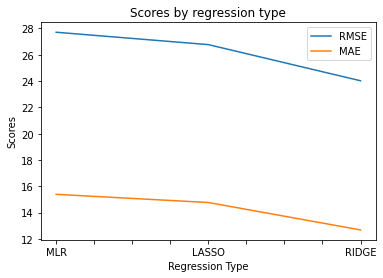

In [41]:
##visualising the scores against the regression type
metric[['RMSE','MAE']].plot()
plt.xlabel('Regression Type')
plt.ylabel('Scores')
plt.title('Scores by regression type')

Text(0.5, 1.0, 'Scores by regression type')

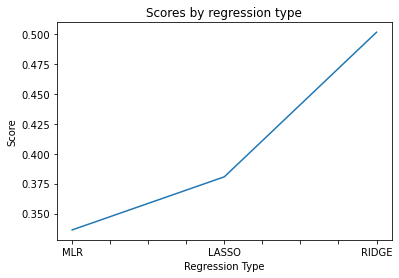

In [42]:
#visualising the r2 score against the r2 score
metric['R2'].plot()
plt.xlabel('Regression Type')
plt.ylabel('Score')
plt.title('Scores by regression type')

#### Ridge performed much better than the rest with the lowest RMSE,MAE and highest R2 score

In [43]:
spark.stop()